<font face="Nunito" size=5>Algorithmic Trading Strategy Using Three Moving Averages & Python
    </font>
    (YouTube)

Strategy:
The 3MS crossover strategy uses 3 moving averages
1. The short/fast MA
2. The middle/medium MA
3. The long/slow MA

Buy & Sell Signals:
There are two Buy/Sell Signals
1. BUY when the mid MA crosses above the long MA, *and* the short MA crosses above the mid MA.
  - implies SELL when the (first part is true) *and* the short MA crosses below the mid MA  
2. BUY when the mid MA crosses below the long MA, *and* the short MA crosses below the mid MA.
  - implies SELL when the (first part is true) *and* the short MA crosses above the mid MA.

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>0. Imports</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.style.use("fivethirtyeight")
%matplotlib inline

<font face="Nunito" size=4>I. Load Data into a DataFrame<br>
<font size=2>
We will be using data for Tesla (TSLA), from 2019-11-18 to 2020-06-09 inclusive of start/end.<br>
Due to changes in Tesla stock, like it becomeing listed in the S\&P500, the historical prices were edited,and don't match the video content.
    </font>

In [2]:
# parse_dates makes sure column 0 is trated as a date
# index_col sets the dates ad the index, instead of having the usual row numbering
# use_cols chooses specific colums fom  the csv instead of all of them:
# In this case we only need the Date and Close. Their indexes are index 0 and index 4.
    # Date, Open, High, Low, Close, Adj Close, Volume
df0 = pd.read_csv("data_files/TSLA.csv", parse_dates=[0],index_col=[0],usecols=[0,4])
df0

,Close
Date,
2019-11-18,69.998001
2019-11-19,71.903999
2019-11-20,70.444000
2019-11-21,70.966003
2019-11-22,66.608002
...,...
2020-06-03,176.591995
2020-06-04,172.876007
2020-06-05,177.132004


<font face="Nunito" size=4>II. Visually Show the Close Price</font>

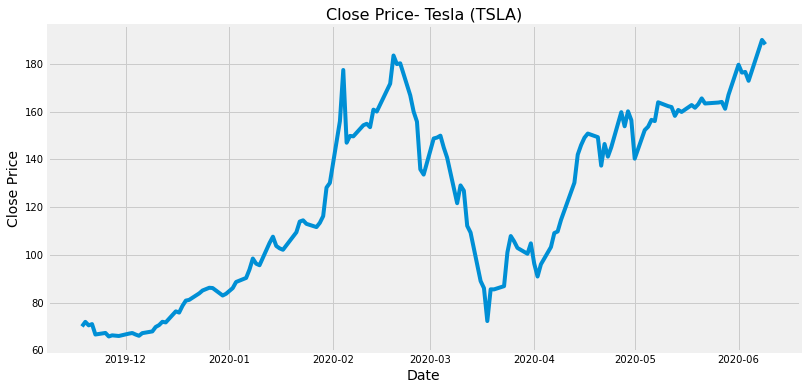

In [3]:
plt.figure(figsize=(12,6))
plt.title("Close Price- Tesla (TSLA)", fontsize=16)
plt.plot(df0)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.show()

<font face="Nunito" size=4>III. Calculate the 3 Moving Averages</font>

In [4]:
# Short Exponentially Weighted Moving Average
SEMA = df0.Close.ewm(span = 5, adjust = False).mean()
# Medium EMA
MEMA = df0.Close.ewm(span = 20, adjust = False).mean()
# Long EMA
LEMA = df0.Close.ewm(span = 60, adjust = False).mean()

<font face="Nunito" size=4>IV. Visualize the Closing Price along with the Moving Averages</font>

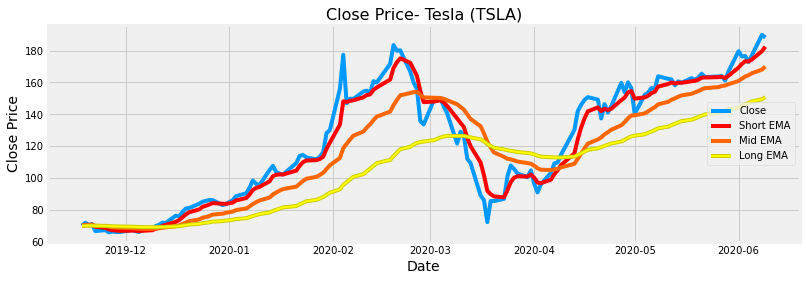

In [5]:
plt.figure(figsize=(12,4))
plt.title("Close Price- Tesla (TSLA)", fontsize=16)
plt.plot(df0, label = "Close", color="#0099ff")
# Now plot the EMA data
plt.plot(SEMA, label = "Short EMA", color="red")
plt.plot(MEMA, label = "Mid EMA", color="#ff6600")
plt.plot(LEMA, label = "Long EMA", color="#ffff00",linewidth=2,
        path_effects=[pe.Stroke(linewidth=4, foreground='#cccc00'), pe.Normal()])
# ----
plt.xlabel("Date", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(loc="center right")
plt.show()

<font face="Nunito" size=4>V. Add the EMAs to the Dataset</font>

In [6]:
df1 = pd.DataFrame.copy(df0)
df1["SEMA"] = SEMA
df1["MEMA"] = MEMA
df1["LEMA"] = LEMA
df1

,Close,SEMA,MEMA,LEMA
Date,,,,
2019-11-18,69.998001,69.998001,69.998001,69.998001
2019-11-19,71.903999,70.633334,70.179525,70.060493
2019-11-20,70.444000,70.570222,70.204713,70.073067
2019-11-21,70.966003,70.702149,70.277217,70.102343
2019-11-22,66.608002,69.337434,69.927768,69.987775
...,...,...,...,...
2020-06-03,176.591995,173.301140,163.725705,146.237432
2020-06-04,172.876007,173.159429,164.597162,147.110828
2020-06-05,177.132004,174.483621,165.790957,148.095128


<font face="Nunito" size=4>VI. Create the Function to Buy and Sell the Stock (i.e. the Strategy)<br><br>
<font size=3>Our data is in ascending order. We will later on `shift()` a series of indicators *down* by one row, such that<br>
&emsp;&emsp; - the indicator for day X is aligned with the data/price for day X+1<br>
&emsp;&emsp; - (alt: the indictor for day X-1 is aligned with data for day X<br>
<br></font></font>

Therfore, we will do this in two parts.
- First: Create the BUY/SELL criteria/indicator/signals. With DataFrames this is sometimes called a *mask*.
- Second: Apply the (boolean) mask to the correct row of data to simulate the buy/sell at that price.



#### VI-0: Strategy Recap and Reformat

1. BUY when the mid MA crosses above the long MA, *and* the short MA crosses above the mid MA.
  - implies SELL when the (first part is true) *and* the short MA crosses below the mid MA  
2. BUY when the mid MA crosses below the long MA, *and* the short MA crosses below the mid MA.
  - implies SELL when the (first part is true) *and* the short MA crosses above the mid MA.
  
---

<font size=3>Encode<br><br></font>
*s,m,l = short,mid,long ; ema = exponentially-weighted moving average*  
Criteria: 
-  I. $mema > lema ~ ?\rightarrow$ Need more info
  - and A. $sema > mema ~ $ BUY
  - OR
  - and B. $sema < mema ~ $ SELL
- II. $mema < lema ~ ?\rightarrow$ Need more info
  - and A. $sema < mema ~ $ BUY
  - OR
  - and B. $sema > mema ~ $ SELL

---
<font size=3>Reformat<br><br></font>
BUY: $When~IA~or~IIA$

SELL: $When~IB~or~IIB$

NOTE: Since we leave out the possibility of $~=~$, we do not get a BUY nor SELL signal on the first day: 2019-11-18.

#### VI-1: Create the Buy and Sell Indicator/Flags/Mask

Mask is just a boolean for every row in the DataFrame, made fomr comparing entries in that row across different columns.  
The following statements evaluate to True or False for each row.

- Note that if our indicators tells us to both Buy and Sell we will get not gains nor losses for that trading day.
- Therfore (since we do not take commission into account) we don't need to combine the signals

In [7]:
# IA or IIA --> (M>L & S>M) or (M<L & S<M)
BuyMask = ((df1.MEMA > df1.LEMA) & (df1.SEMA > df1.MEMA)) | ((df1.MEMA < df1.LEMA) & (df1.SEMA < df1.MEMA))

# IB or IIB --> (M>L & S<M) or (M<L & S>M)
SellMask = ((df1.MEMA > df1.LEMA) & (df1.SEMA < df1.MEMA)) | ((df1.MEMA < df1.LEMA) & (df1.SEMA > df1.MEMA))

# Finally, we add these to the DataFrame
df1["Buy"] = BuyMask
df1["Sell"] = SellMask

# A quick test showing that outside of the first day, we have no ambigous signal to both buy and sell
    # np.logical_not take the opposite of the value its given. Thus is turns True into False and cvice versa
b_or_s = BuyMask[1:] == np.logical_not(SellMask[1:])

print(f"BuyMask[0:5], values only\n {BuyMask.values[:5]}")
#print(f"\ttype(BuyMask) : {type(BuyMask)}")
print()
print(f"SellMask[:5], with Date index\n {SellMask.head()}")
#print(f"\ttype(SellMask) : {type(SellMask)}")

print("""\n\tIf 'when to Buy' and 'when to Sell' are opposites, then this summary of 
\tcomparing one to the opposite of the other, will show that there's only 1 unique value.""")
print(b_or_s.describe())

BuyMask[0:5], values only
 [False  True  True  True  True]

SellMask[:5], with Date index
 Date
2019-11-18    False
2019-11-19    False
2019-11-20    False
2019-11-21    False
2019-11-22    False
dtype: bool

	If 'when to Buy' and 'when to Sell' are opposites, then this summary of 
	comparing one to the opposite of the other, will show that there's only 1 unique value.
count      139
unique       1
top       True
freq       139
dtype: object


- $\Downarrow$ our new DataFrame, for reference

In [8]:
df1

,Close,SEMA,MEMA,LEMA,Buy,Sell
Date,,,,,,
2019-11-18,69.998001,69.998001,69.998001,69.998001,False,False
2019-11-19,71.903999,70.633334,70.179525,70.060493,True,False
2019-11-20,70.444000,70.570222,70.204713,70.073067,True,False
2019-11-21,70.966003,70.702149,70.277217,70.102343,True,False
2019-11-22,66.608002,69.337434,69.927768,69.987775,True,False
...,...,...,...,...,...,...
2020-06-03,176.591995,173.301140,163.725705,146.237432,True,False
2020-06-04,172.876007,173.159429,164.597162,147.110828,True,False
2020-06-05,177.132004,174.483621,165.790957,148.095128,True,False


#### VI-2:  Apply the (boolean) mask to the correct row of data

This was not done in the video and is extra. Now that we have signals for each day, we can use this signal to tell use what to do tomorrow. Therefore, we can consider tomorrows gain/loss our own gain/loss if we had followed the strategy.

We verified using `np.logical_not` that our Buy and Sell columns were just opposites. Again, this is ignoring day one, because all EMAs have an **equal** value on that day, and out strategy only uses $>$ or$<~$. In any case, this means we only need **one** of the columns. If Buy is `True`, we know Sell is `False`, and if Buy is `False`, we know Sell is `True`. No need to check the other column.

**Magic Formula**  
Gain or Loss / Profit or Loss/ PnL equals:  
$\Rightarrow$ (True or False inidcator yesterday) $~\times~$ Today's Price Change
- In Python `True` is `1` and `False` is `0` so `True * -4` = -4, and `False * -2.5` = 0
- Obviously the positive number case works the same way. We use this to determine PnL.
- You can use absolute change and aggregate with addition or percent change and aggreate with multiplication.

In [9]:
# Make a colum for the price change from yesterday. 
#Since our data is with ascending dates when don't need to change default parameters
df1["PercentChange"] = df1.Close.pct_change()
df1["PriceChange"] = df1.Close.diff()
df1[14:21]

,Close,SEMA,MEMA,LEMA,Buy,Sell,PercentChange,PriceChange
Date,,,,,,,,
2019-12-09,67.905998,67.163069,67.962049,69.071735,True,False,0.010837,0.727997
2019-12-10,69.767998,68.031379,68.134044,69.094563,True,False,0.027420,1.862000
2019-12-11,70.540001,68.867586,68.363183,69.141955,False,True,0.011065,0.772003
2019-12-12,71.935997,69.890390,68.703451,69.233563,False,True,0.019790,1.395996
2019-12-13,71.678001,70.486260,68.986742,69.313708,False,True,-0.003586,-0.257996
2019-12-16,76.300003,72.424174,69.683243,69.542767,True,False,0.064483,4.622002
2019-12-17,75.797997,73.548782,70.265600,69.747857,True,False,-0.006579,-0.502006


In [10]:
# Calculate daily PnL (Profit and Loss)
PnL = df1.PriceChange * df1.Buy
PnL[13:22]

Date
2019-12-06    1.104004
2019-12-09    0.727997
2019-12-10    1.862000
2019-12-11    0.000000
2019-12-12    0.000000
2019-12-13   -0.000000
2019-12-16    4.622002
2019-12-17   -0.502006
2019-12-18    2.832000
dtype: float64

# CREATE a column that does OR or the Buy & Sell Columns
## otherwise, on days you should sell, if the buy column is False, but you gained/loss o that day, the strategy will record 0, since False * PriceChange = 0

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>

<font face="Nunito" size=4>...</font>